In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from glob import glob
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import imutils
import shutil
from tqdm import tqdm

root_dir = "./brain_tumor_dataset/"
num_samples = len(os.listdir("./no")) + len(os.listdir("./yes")) 
print("Number of samples: " + str(num_samples)) 


Number of samples: 253


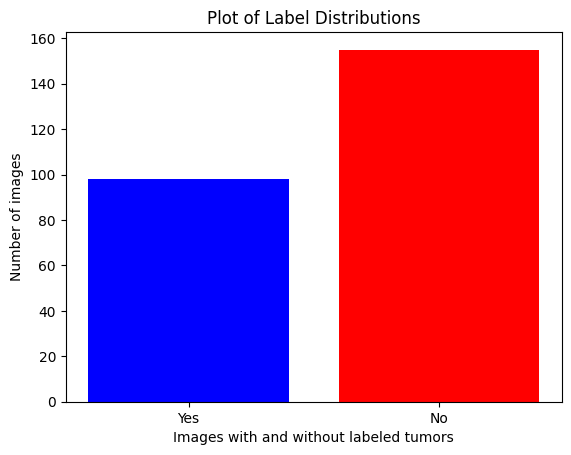

In [3]:
class_labels = ["Yes", "No"]
counts = [len(os.listdir("./no")), len(os.listdir("./yes"))]
colors = ['blue', 'red']

fig, axs = plt.subplots()
axs.bar(class_labels, counts, color= colors)
axs.set_ylabel('Number of images')
axs.set_xlabel('Images with and without labeled tumors')
axs.set_title('Plot of Label Distributions')
fig.savefig("./label-distributions.jpeg")

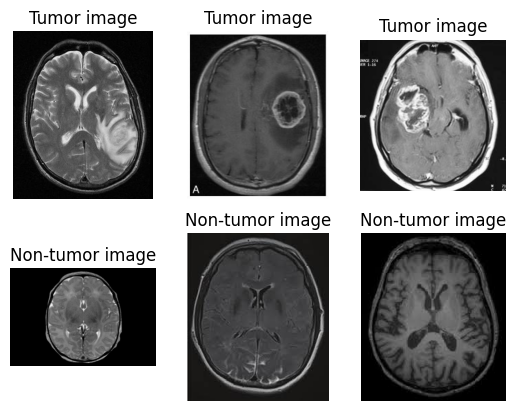

In [56]:
yes_files = glob('./yes/*')
no_files = glob('./no/*')


example_yes_images = [plt.imread(image) for image in yes_files[:3]]
example_no_images = [plt.imread(image) for image in no_files[:3]]

fig, axs = plt.subplots(2,3)
for i in range(3):
        axs[0][i].imshow(example_yes_images[i], cmap = 'gray')
        axs[0][i].axis("off")
        axs[0][i].set_title(f'Tumor image')
        #axs[0][i].text(0.5, -0.15, "Size, ", horizontalalignment='center', verticalalignment='center', transform=axs[0][i].transAxes, fontsize=10)
        axs[1][i].imshow(example_no_images[i], cmap = 'gray')
        axs[1][i].axis("off")
        axs[1][i].set_title(f'Non-tumor image')

fig.savefig("./unprocessed-figure.jpeg")

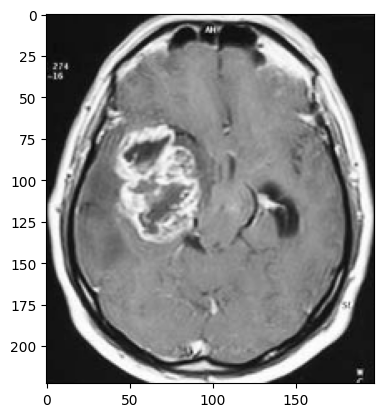

In [44]:
# Function to perform image preprocessing.
# Tutorial credit for this goes to Adrian Rosebrock at pyimagesearch
def pre_process(image):
    img = cv2.imread(image, 1)
    img = cv2.resize(
                img,
                dsize=(224,224),
                interpolation=cv2.INTER_CUBIC
            )
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # add contour on the image
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

    # add extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

output_yes_dir = "./yes_processed/"
output_no_dir = "./no_processed/"

In [46]:
output_yes_dir = "./yes_processed/"
output_no_dir = "./no_processed/"

def crop_brain_images(input_dir, output_dir):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get a list of all image files in the input directory
    
    for img in input_dir:
        new_image = pre_process(img)
        output_file = os.path.join(output_dir, os.path.basename(img))
        cv2.imwrite(output_file, new_image)

crop_brain_images(yes_files, output_yes_dir)
crop_brain_images(no_files, output_no_dir)

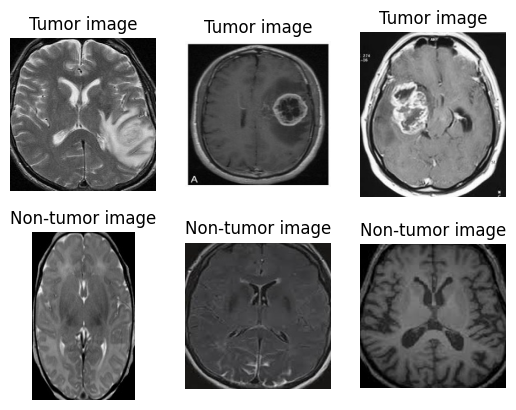

In [57]:
yes_files = glob('./yes_processed/*')
no_files = glob('./no_processed/*')

example_yes_images = [plt.imread(image) for image in yes_files[:3]]
example_no_images = [plt.imread(image) for image in no_files[:3]]

fig, axs = plt.subplots(2,3)
for i in range(3):
        axs[0][i].imshow(example_yes_images[i], cmap = 'gray')
        axs[0][i].axis("off")
        axs[0][i].set_title(f'Tumor image')
        #axs[0][i].text(0.5, -0.15, "Size, ", horizontalalignment='center', verticalalignment='center', transform=axs[0][i].transAxes, fontsize=10)
        axs[1][i].imshow(example_no_images[i], cmap = 'gray')
        axs[1][i].axis("off")
        axs[1][i].set_title(f'Non-tumor image')

fig.savefig("./cropped-figure.jpeg")